# Notebook assigment

# Motivation


* What is your dataset?

* Why did you choose this/these particular dataset(s)?

* What was your goal for the end user’s experience?

Our data resolves around music. We have four different types of data sets. 

________

The first, is a ranked list of songs (with the artist of the song) which have been spending the most time on the spotify U.S. charts counting in the period 2013-2023, https://kworb.net/spotify/country/us_weekly_totals.html. The list is ranking 7653 different songs. This data set is used to get a list of artist primarily singing in the English language. By taking the set of these, 1250 unique artist from the top charst are left, who all atleast has had one major song. 
Also, data is collected from the spotify-API, https://developer.spotify.com/documentation/web-api. Here, the genres of the artist are collected as well as the features of that artist. The features enables us to make connections between artists, and by using the genres of the artist a broader analysis can be made.
Finally, the lyrics from the three most popular songs of each artist are collected in order to do text analysis, collected from Genius, https://docs.genius.com.

The main research questions for the project are: 

1. Artists under which genres have the most collaborations?
2. How likely are inter-genre collaborations and which of these are most common?




# Basic stats. Let’s understand the dataset better


* Write about your choices in data cleaning and preprocessing

    - Is the list actually top artists
    - Some songs are included multiple times (because remix' etc. )
    - Determination of genre
    

* Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

_________

A number of assumptions are done to get to the final data set, which is used to form the network and make basic descriptive stats. The most important preprocessing involves getting the top-genre for each artist, since spotify can associate multi genres per artist. This will be elaborated after the loading of the data.



## _Get dependencies_

In [4]:
import math
import json
import requests
import itertools
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
import json
import base64
import itertools
from tqdm.auto import tqdm
import pickle
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain
import netwulf as nw

/Users/carlschmidt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## _Load data_

### 1. Top charts artist
Loading of the ranked top charts and the artist of the songs into a dataframe - we take the set of artists:

In [5]:
df_charts_artist = pd.read_csv('artists_charts.csv')
unique_artists = df_charts_artist['artist'].unique()
unique_artists
df_charts_artist.head()

,artist,song
0,Post Malone,Sunflower
1,Juice WRLD,Lucid Dreams
2,Lil Uzi Vert,XO TOUR Llif3
3,J. Cole,No Role Modelz
4,Post Malone,rockstar


As it can be seen Post Malone's song: "Sunflower" has spend the most time on the U.S. top charts. The general statistics from the dataframe can be seen below:

In [6]:
df_charts_artist.describe()

,artist,song
count,7651,7650
unique,1250,6922
top,Drake,Intro
freq,205,8


There are 7651 artist and 1250 unique ones. Drake appear the most on this list with 205 songs. One song seem to be missing since there are 7650 songs. Songs with the same name appears on the list, with eight songs called: "Intro". A common title for the first song on an album. 

### 2. Features and Genres

We read the spotify features and genres for each artist into two dictionaries:

In [7]:
def read_files(input = False):
    if input:
        with open('dict_featuresALL-modified.pickle', 'rb') as handle:
            dict_features = pickle.load(handle)

        with open('dict_genresALL-modified.pickle', 'rb') as handle:
            dict_genres = pickle.load(handle)
        return dict_features, dict_genres
    else:
        pass
    
dict_features, dict_genres = read_files(True)

#### Features

The features are assembled by collecting every spotify song of the artist which has a list of performers on the track. We have assumed that all remixes of a song is a seperate song and the features from a specific song and the remixed songs will therefore be collected. This might is unfair since it is not exactly a new collaboration with the artist that some extra bass is added to the song. However, artists often form a song, and then later make a "remix" which includes a new feature on it. Thus, we go with remixes as well.


The first 5 features for each artist (formatted without id): 

In [8]:
dict_features_copy = {}
for k,v in dict_features.items():
    only_names = [va[0] for va in v]
    dict_features_copy[k[0]] = only_names

# pd dataframe from dict_features
df_features = pd.DataFrame.from_dict(dict_features_copy, orient='index')
df_features.T.head()

,Post Malone,Juice WRLD,Lil Uzi Vert,J. Cole,Travis Scott,The Weeknd,XXXTENTACION,Lil Baby,Kendrick Lamar,Glass Animals,...,My Morning Jacket,Kid Rock,Jarryd James,Rebel Wilson,Ciara,Christina Aguilera,The Temptations,Das Sound Machine,Death Cab for Cutie,Purity Ring
0,Roddy Ricch,Justin Bieber,Future,Dreamville,ROSALÍA,Daft Punk,Ski Mask The Slump God,Nardo Wick,Blxst,Denzel Curry,...,None,Monster Truck,Trapo,Andrew Lloyd Webber,Macklemore,Lil' Kim,K. Sparks,None,None,Young Magic
1,Doja Cat,Polo G,Future,JID,Lil Baby,Lana Del Rey,PnB Rock,Young Thug,Amanda Reifer,Hudson Mohawke,...,None,Robert James,BROODS,"Cast Of The Motion Picture ""Cats""",Kelly Rowland,Redman,Smokey Robinson,None,None,Deftones
2,Gunna,Trippie Redd,Future,Kenny Mason,JACKBOYS,Kendrick Lamar,Trippie Redd,Fridayy,Sampha,Raz & Afla,...,None,Martina McBride,Raury,Robbie Fairchild,Tekno,Becky G,John Forte,None,None,Deftones
3,Fleet Foxes,SUGA,Future,Sheck Wes,JACKBOYS,Future,Lil Wayne,Future,Taylour Paige,Kelly Lee Owens,...,None,T.I.,Julia Stone,Jason Derulo,Pitbull,Nicki Nicole,Four Tops,None,None,Deftones
4,The Kid LAROI,BTS,Future,Dreamville,Sheck Wes,Daft Punk,Rick Ross,Rylo Rodriguez,Summer Walker,Denzel Curry,...,None,Sheryl Crow,None,James Corden,Missy Elliott,NATHY PELUSO,Rick James,None,None,Deftones


The descriptive statistics tells us each artist favorite feature on his/her/their songs and how many times they appear:

In [9]:
df_features.T.describe()

,Post Malone,Juice WRLD,Lil Uzi Vert,J. Cole,Travis Scott,The Weeknd,XXXTENTACION,Lil Baby,Kendrick Lamar,Glass Animals,...,My Morning Jacket,Kid Rock,Jarryd James,Rebel Wilson,Ciara,Christina Aguilera,The Temptations,Das Sound Machine,Death Cab for Cutie,Purity Ring
count,39,41,58,282,56,58,124,112,79,19,...,0,11,4,44,43,29,15,0,0,70
unique,25,21,15,74,22,23,44,38,57,17,...,0,10,4,21,26,26,6,0,0,24
top,Quavo,Future,Future,Dreamville,Quavo,Simon Franglen,Kin$oul,Lil Durk,Anna Wise,Denzel Curry,...,NaN,Sheryl Crow,Trapo,John Debney,Missy Elliott,Lil' Kim,Diana Ross & The Supremes,NaN,NaN,Deftones
freq,3,15,36,69,15,19,13,19,4,3,...,NaN,2,1,17,4,2,10,NaN,NaN,20


#### Genres
Here are both "all genres" for each artist (determined by spotify) and the top genre (determined by us):

In [10]:
dict_genres_copy = {}
for k,v in dict_genres.items():
    dict_genres_copy[k[0]] = v
pd.DataFrame.from_dict(dict_genres_copy).head()

,Post Malone,Juice WRLD,Lil Uzi Vert,J. Cole,Travis Scott,The Weeknd,XXXTENTACION,Lil Baby,Kendrick Lamar,Glass Animals,...,My Morning Jacket,Kid Rock,Jarryd James,Rebel Wilson,Ciara,Christina Aguilera,The Temptations,Das Sound Machine,Death Cab for Cutie,Purity Ring
all_genres,"[dfw rap, melodic rap, pop, rap]","[chicago rap, melodic rap, rap]","[melodic rap, philly rap, rap]","[conscious hip hop, hip hop, north carolina hi...","[hip hop, rap, slap house]","[canadian contemporary r&b, canadian pop, pop]","[emo rap, miami hip hop]","[atl hip hop, atl trap, rap, trap]","[conscious hip hop, hip hop, rap, west coast rap]","[gauze pop, indietronica, modern rock, shiver ...",...,"[chamber pop, indie rock, jam band, louisville...",[nu metal],"[australian alternative pop, australian r&b]",[australian comedy],"[dance pop, hip pop, pop, r&b, urban contempor...","[dance pop, pop]","[memphis soul, motown, soul]",[no_genres],"[alternative rock, chamber pop, indie rock, in...","[canadian electropop, dark pop, edmonton indie..."
top genre,rap,rap,rap,hip-hop,house,pop,hip-hop,trap,rap,pop,...,rock,metal,r&b,comedy,pop,pop,soul,No genres,indie,pop


Since the genre is important for the rest of the work, we will look into how the top genre was formed by us. First we define a plot function to help us visualize the preprocessing:

In [11]:
def make_hist_of_genres(dict_genres, key_to_use: str, top_n= 20):
    list_of_genres = []
    for dict in dict_genres.values():
        list_of_genres.append(dict[key_to_use])

    if key_to_use == 'all_genres':
        all_genres = list(itertools.chain(*list_of_genres))
        #all_genres = [genre for genre in all_genres if genre != '']
    else:
        all_genres = list_of_genres
    # Make the plot with seaborn
    sns.set_style("whitegrid")
    plt.figure(figsize=(12,3))
    ax = sns.countplot(x=all_genres, order=pd.value_counts(all_genres).iloc[:top_n].index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.title(f'Top {top_n} genres', fontsize=20)
    props = {'boxstyle': 'round', 'facecolor': 'grey', 'alpha': 0.5}

    #props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
    ax.text(0.67, 0.92, f' Number of genres collected:  {3623} \n Number of unique genres:      {569}', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    plt.show()
    return all_genres

We plot the distribution of "all genres" for the 20 most frequent:

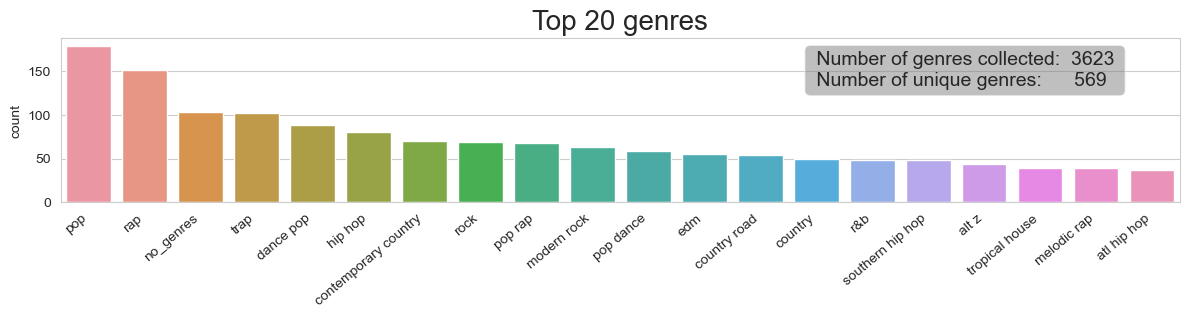

In [12]:
all_genres = make_hist_of_genres(dict_genres, 'all_genres')

On average each artist has around 3 different genres associated with them. The task is now to form exactly one genre per artist, i.e. the top genre. 
From the plot it can be seen that 103 artists have no genre. These will be removed. 
It is also visible that many genres somewhat overlap. For example, "contemporary country" and "country road" can be considered genres under "country". The idea is that we do not differentiate between types under a broader genre. Some might argue that rap is a genre under hip-hop, however, we also try to avoid deleting too many genres. 

By splitting each artist genres into word tokens, we can for example count how many times the word "pop" and "r&b" appears, and then take the most frequent one-word genre - where the genres defined are the ones spotify have defined. This is an example from the artist "The Weeknd":


In [14]:
artist_str, value_str, splitter_str = 'The Weeknd', 'all_genres', ' '
print(f'All genres from The Weeknd:                                                         {dict_genres_copy[artist_str][value_str]}')
print(f'Split by words. Word tokens:                                                        {list(itertools.chain(*[genre.split(splitter_str) for genre in dict_genres_copy[artist_str][value_str]]) )}')
print(f'Count frequent word tokens. Counted Word tokens:                                    {Counter(list(itertools.chain(*[genre.split(splitter_str) for genre in dict_genres_copy[artist_str][value_str]]) )).most_common()}')
print('Check if the most frequent word tokens are in a defined list of genres. Top-genre:  [\'pop\']')


All genres from The Weeknd:                                                         ['canadian contemporary r&b', 'canadian pop', 'pop']
Split by words. Word tokens::                                                       ['canadian', 'contemporary', 'r&b', 'canadian', 'pop', 'pop']
Count frequent word tokens. Counted Word tokens:                                    [('canadian', 2), ('pop', 2), ('contemporary', 1), ('r&b', 1)]
Check if the most frequent word tokens are in a defined list of genres. Top-genre:  ['pop']


Exceptions are which can arise:
* Having multiple word tokens which are genres. Here, we choose randomly. 
* Having a genre, but no word tokens fit with the defined list of genres. Solved by choosing randomly from the list of all genres without splitting into word tokens. 
* Having zero genres. 

# Tools, theory and analysis. Describe the process of theory to insight


Talk about how you’ve worked with text, including regular expressions, unicode, etc.

Describe which network science tools and data analysis strategies you’ve used, how those network science measures work, and why the tools you’ve chosen are right for the problem you’re solving.

How did you use the tools to understand your dataset?

# Discussion. Think critically about your creation



What went well?

What is still missing? What could be improved? Why?